# CIFAR classification in Fully Homomorphic Encryption (FHE) with Rounding Accumulators


In notebooks [1](./FromImageNetToCifar.ipynb), [2](./CifarQuantizationAwareTraining.ipynb) and [3](./CifarInFhe.ipynb), we showed how to convert any custom NN into its FHE counterpart respecting the FHE constraints. Then, how to evaluate it in FHE simulation mode. Pure FHE computation will be available in the next releases.

During those tutorials, you may have experienced some slowness of FHE computations, which is intimately related to non-linear crypto operations on large accumulator size. 

In this tutorial we present a new way to speed up computations by cancelling the least-significant bits of the accumulator, and thus having PBS of smaller precision. This technique reduces the FHE-circuit complexity while maintaining high accuracy.

### Import the required packages

In [1]:
import warnings
from typing import Callable, List, Tuple

import matplotlib.pyplot as plt
import torch
from cifar_utils import fhe_simulation_inference, get_dataloader, torch_inference
from models import QuantVGG11
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets

from concrete.ml.torch.compile import compile_brevitas_qat_model

warnings.filterwarnings("ignore", category=UserWarning)

### Settings 

In [2]:
bit = 5
seed = 42
rounding_thresholds_bits = [8, 7, 6, 5, 3]

device = "cuda" if torch.cuda.is_available() else "cpu"

We define a function that evaluates models based on a range of rounding values.

In [3]:
def accuracy_with_diff_rounding_thresholds_bits(
    model: Callable,
    X_train: torch.Tensor,
    test_loader: DataLoader,
) -> Tuple[List]:
    """Evaluate the model with different rounding values"""

    accuracy_fhe_simulation, accuracy_torch = [], []

    acc_torch = torch_inference(model, test_loader, device, True)

    for max_bitwidth in rounding_thresholds_bits:
        qmodel = compile_brevitas_qat_model(
            model.to("cpu"),
            torch_inputset=X_train,
            rounding_threshold_bits=max_bitwidth,
        )

        acc_fhe_s = fhe_simulation_inference(qmodel, test_loader, True)

        accuracy_torch.append(round(acc_torch, 4))
        accuracy_fhe_simulation.append(round(acc_fhe_s, 4))

    return accuracy_fhe_simulation[::], accuracy_torch[::]

In [4]:
def plot_accuracy(acc_torch: List[float], acc_fhe: List[float], title: str) -> None:
    """Plot the Concrete accuracy based on different rounding values vs Torch accuracy"""

    plt.figure(figsize=(15, 6))
    plt.plot(rounding_thresholds_bits, acc_fhe, "o-", label="Acc with FHE simulation")
    plt.plot(rounding_thresholds_bits, acc_torch, "o-", label="Acc with Torch")

    for bits, acc in zip(rounding_thresholds_bits, acc_fhe):
        plt.gca().annotate(f"{acc:.2f}", (bits - 0.1, acc + 0.01))

    plt.title(f"{title} - FHE accuracy according to different threshold values")
    plt.xlabel("Rounding thresholds")
    plt.ylabel("Top-1 accuracy")

    plt.xticks(rounding_thresholds_bits)
    plt.gca().invert_xaxis()
    plt.ylim(-0.02, 1.1)
    plt.grid(True)
    plt.legend()
    plt.show()

## 1. CIFAR-10

In [5]:
param_c10 = {
    "output_size": 10,
    # Small and representative input-set to be used for both quantization and compilation
    "calibration_dataset_size": 10,
    # We evaluate the model on 500 examples
    "dataset_size": 500,
    "batch_size": 10,
    "dataset_name": "CIFAR_10",
    "dataset": datasets.CIFAR10,
    "std": [0.247, 0.243, 0.261],
    "mean": [0.4914, 0.4822, 0.4465],
    "dir": "./checkpoints/CIFAR_10",
    "pre_trained_path": "quant/CIFAR_10_quant_state_dict.pt",
    "seed": 42,
}

### Pre-trained quantized model

As for [CifarInFhe](./CifarInFhe.ipynb) notebook, we load the pre-trained quantized model.

In [6]:
quant_vgg_c10 = QuantVGG11(bit=bit, output_size=param_c10["output_size"])

checkpoint = torch.load(f"{param_c10['dir']}/{param_c10['pre_trained_path']}", map_location=device)

quant_vgg_c10.load_state_dict(checkpoint)

<All keys matched successfully>

### Cifar-10 data-set

In [7]:
# For the safe of simplicity, we use a small subset:
# - from the train set to be used for both quantization and compilation
# - from the testing set to evaluate the model with the rounding accumulator feature

train_loader_c10, test_loader_c10 = get_dataloader(param=param_c10)

calibration_data_c10, _ = next(iter(train_loader_c10))

Files already downloaded and verified
Files already downloaded and verified


### Rounding accumulators

To show the effect of the rounding accumulators feature, we test all possible rounding values, starting from `qmodel.fhe_circuit.graph.maximum_integer_bit_width()`, which is 14 is our case.

In [8]:
acc_fhe_c10, acc_torch_c10 = accuracy_with_diff_rounding_thresholds_bits(
    quant_vgg_c10,
    calibration_data_c10,
    test_loader_c10,
)

100%|██████████| 50/50 [06:48<00:00,  8.16s/it]


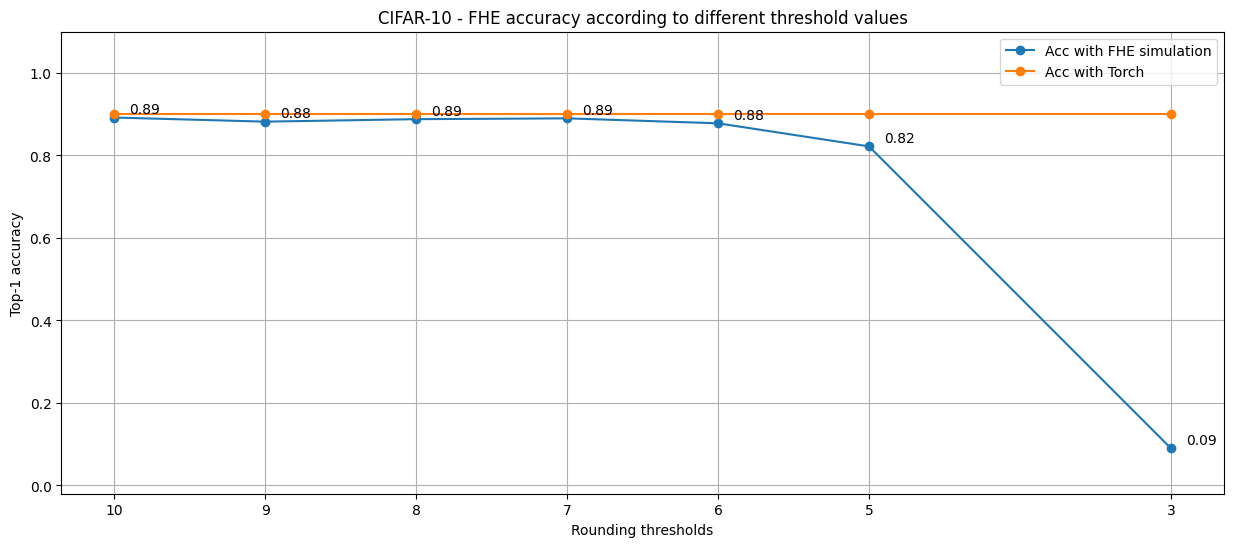

In [9]:
plot_accuracy(acc_torch_c10, acc_fhe_c10, title="CIFAR-10")

The maximum size of the accumulator of this model is 14. However, rounding to 6-bits gives an interesting compromise between accuracy and computation time in FHE.

## 2. CIFAR-100

Since the methodology is the same, we do exactly the same thing but this time with the CIFAR-100 hyper-parameters.

In [10]:
param_c100 = {
    "output_size": 100,
    # Small and representative input-set to be used for both quantization and compilation
    "calibration_dataset_size": 10,
    # We evaluate the model on 100 examples
    "dataset_size": 500,
    "batch_size": 10,
    "dataset_name": "CIFAR_100",
    "dataset": datasets.CIFAR100,
    "std": [0.229, 0.224, 0.225],
    "mean": [0.485, 0.456, 0.406],
    "dir": "./checkpoints/CIFAR_100",
    "pre_trained_path": "quant/CIFAR_100_quant_state_dict.pt",
    "seed": 42,
}

### Pre-trained quantized model

In [11]:
# Loading the pre-trained quantized model
quant_vgg_c100 = QuantVGG11(bit=bit, output_size=param_c100["output_size"])

checkpoint = torch.load(
    f"{param_c100['dir']}/{param_c100['pre_trained_path']}", map_location=device
)

quant_vgg_c100.load_state_dict(checkpoint)

<All keys matched successfully>

### Cifar-100 data-set

In [12]:
train_loader_c100, test_loader_c100 = get_dataloader(param=param_c100)

calibration_data_c100, _ = next(iter(train_loader_c100))

Files already downloaded and verified
Files already downloaded and verified


### Rounding accumulators

In [26]:
acc_fhe_c100, acc_torch_c100 = [], []

acc_fhe_c100, acc_torch_c100 = accuracy_with_diff_rounding_thresholds_bits(
    quant_vgg_c100, calibration_data_c100, test_loader_c100
)

100%|██████████| 50/50 [06:29<00:00,  7.80s/it]


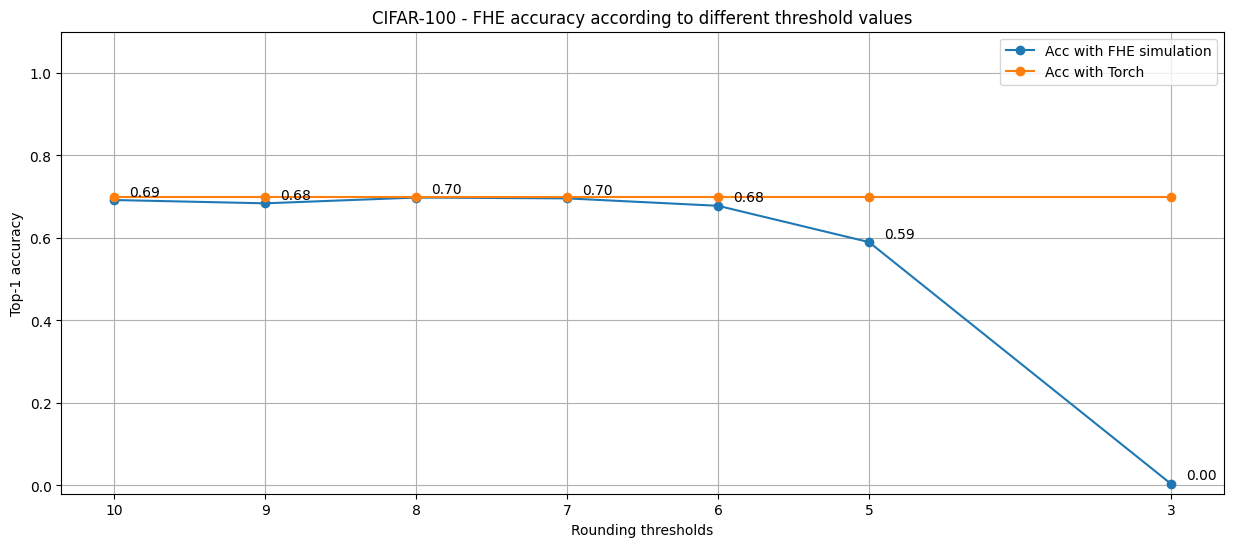

In [27]:
plot_accuracy(acc_torch_c100, acc_fhe_c100, title="CIFAR-100")

The maximum size of the accumulator of this model is 14. However, rounding to 6-bits gives the same accuracy and decreases the complexity of the FHE-circuit.

### Conclusion

Before running a model in FHE, it is always recommended to start with the FHE simulation. This allows to understand the complexity of the ML model and therefore to explore new strategies to find an interesting trade-off between accuracy and computation time.

**The rounding accumulator** is a good technique that speeds up the computation while maintaining a high accuracy.